In [9]:
from urllib import request
import json
import pandas as pd
from itertools import product
import numpy as np
from time import sleep
import time
import geopandas as gpd

## American Community Survey -- data queries
original script can be found in the repository of 'Universal patterns of long-distance commuting and social assortativity in cities' as '_script09-C_census_data_top25.ipynb'

In [2]:
# prep data to query on the top 50 metro areas
metrodata = pd.read_csv('../data/cbsa-est2018-alldata.csv', encoding = "ISO-8859-1")
metrodata = metrodata.drop_duplicates(subset=["CBSA"])
metrodata = metrodata.loc[:,["CBSA","NAME","CENSUS2010POP"]].drop_duplicates().sort_values(by="CENSUS2010POP",ascending=False).reset_index(drop=True)
metrodata = metrodata.reset_index().reset_index()[["level_0","CBSA","NAME","CENSUS2010POP"]]
metrodata.rename({"level_0":"rank","CBSA":"cbsacode","NAME":"name","CENSUS2010POP":"population"},axis=1,inplace=True)
metrodata["short_name"] = metrodata["name"].map(lambda s: s.split("-")[0].split(",")[0])

# filter mterodata to top50
top50 = metrodata[metrodata['population'] > metrodata.iloc[50]['population']]

In [3]:
# get fips
metro_to_county = pd.read_csv('../data/cbsa2fipsxw.csv')
metro_to_county = metro_to_county.loc[:,['cbsacode', 'fipsstatecode', 'fipscountycode']].dropna()

metro_to_county['cbsacode'] = metro_to_county['cbsacode'].map(int)
metro_to_county.set_index('cbsacode',inplace=True)

In [4]:
# dataframe with all the information for the queries
to_query = pd.merge(top50, metro_to_county,how='left',left_on='cbsacode',right_index=True)[['rank','short_name','cbsacode','fipsstatecode','fipscountycode']].dropna()
to_query.shape

(426, 5)

In [5]:
# ACS codes for data we are interested in
code_list = {
    "B01003_001":"population",
    "B15003_022":"education_bachelor", 
    "B15003_001":"education_total", 
    "B19301_001":"income",
    "B02001_001":"race_total",
    "B02001_002":"white",
    "B02001_003":"black",
    "B02001_004":"native",
    "B02001_005":"asian"
}

# retrieving the estimates and their errors
mode_list = {
    "E":"",
    "M":"_error"
}

In [6]:
def create_query(code,mode,state,county):
    """
    ACS 5-year estimate API queries.
    
    See https://www.census.gov/content/dam/Census/data/developers/api-user-guide/api-guide.pdf for details.
    """
    query = \
        'https://api.census.gov/data/2020/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get='+\
        code+\
        mode+\
        '&&for=tract:*&in=state:'+\
        str(state).zfill(2)+\
        '+county:'+\
        str(county).zfill(3)
        
    return query

In [7]:
def get_data(query):
    """
    For a given ACS code (variable) and mode (estimate/margin of error), using the query, 
    returns a nicely formatted dataframe with the results.
    """
    try:
        # this line returns a response object
        raw_response = request.urlopen(
            query
        )
        # reading the string content from the response object (as if it were an open file)
        str_response = raw_response.read()
        #print(str_response)
    except:
        # jump if there is an error, e.g. because the API blocks us
        str_response = ''

    if str_response!='':
        # if we got a response, parse the string into a list of lists
        parsed_response = json.loads(str_response)
        # first line is the header, rest is the data, convert data to DataFrame
        data = pd.DataFrame(parsed_response[1:])
        # renaming variable name to human readable form
        # parsed_response[0][0] = code_list[code]+mode_list[mode]
        # passing column names to the data
        data.columns =  parsed_response[0]
        # indexing data by geography for join purposes
        data.set_index(['state','county','tract'],inplace=True)
        return data

In [8]:
# creating queries for the selected top metro areas
def create_query_list(state,county):
    """
    Creates all the queries for a given county based on the codes and modes listed in code_list and mode_list.
    """
    return [create_query(code,mode,state,county) for code,mode in product(code_list,mode_list)]

In [9]:
# actually creating all the queries in the dataframe
to_query['queries'] = to_query[['fipsstatecode','fipscountycode']].apply(
    lambda r: create_query_list(int(r['fipsstatecode']),int(r['fipscountycode'])),axis=1
)

In [10]:
header_flag=True

def save_query_results(f,qlist):
    """
    Saving query results into file continuously.
    """
    # use outside reference of header_flag within function
    global header_flag
    # open output file for writing in append mode
    file = open(f,'a')
    try:
        # get parsed response for all queries in query list created earlier
        temp = list(map(get_data,qlist))
    except:
        # if there is no response, print queries
        print("\n".join(qlist))
    try:
        # combine query results into one dataframe, putting education, race etc. columns together
        # rows are different census tracts
        df = pd.concat(temp,axis=1)
        # rename columns from codes to human readable form
        df.columns = [code_list[c[:-1]]+mode_list[c[-1]] for c in df.columns]
        # write combined dataframe to output file
        # if this is the first output, write header
        df.to_csv(file,index=True,header=header_flag)
        # if this is not the first output, omit header
        header_flag=False
        # close file
        file.close()
        return df
    
    except ValueError:
        print("\n".join(qlist))

In [12]:
to_query.shape

(426, 6)

In [ ]:
# looping over the desired queries
start_time = time.time()

f = '../data/censusdata-top50-2020.csv'

# clearing file
open(f,'w').close()
header_flag=True
to_query['results'] = to_query['queries'].map(lambda qlist: save_query_results(f,qlist))

print("--- %s seconds ---" % round((time.time() - start_time), 3))

In [37]:
print('\n'.join(to_query['queries'].map(lambda l: '\n'.join(l))))

https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B01003_001E&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B01003_001M&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B15003_022E&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B15003_022M&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B15003_001E&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B15003_001M&&for=tract:*&in=state:34+county:003
https://api.census.gov/data/2016/acs/acs5?key=247942759169865ffc196d2f9fce9e9c94fc738b&get=B19301_001E&&for=tract:*&in=state:34+county:003
https://api.census.gov/data

In [92]:
pd.read_csv('../data/censusdata_missing_top25.csv')

,state,county,tract,population,population_error,education_bachelor,education_bachelor_error,education_total,education_total_error,income,...,race_total,race_total_error,white,white_error,black,black_error,native,native_error,asian,asian_error
0,48,201,551702,3954,254,864,143,2746,177,51367.0,...,3954,254,2408,222,70,61,0,13,1025,194
1,48,201,551701,9148,848,1754,441,5998,420,33785.0,...,9148,848,6262,913,1062,540,0,19,1004,171
2,48,201,550601,7212,446,444,113,4204,293,23316.0,...,7212,446,2862,560,2873,416,0,19,281,143
3,48,201,550402,11168,863,577,236,6718,445,22523.0,...,11168,863,1742,604,7474,799,39,51,861,356
4,48,201,550301,7750,749,293,152,4116,357,16598.0,...,7750,749,2537,641,4197,589,0,19,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1101,27,139,80302,15780,563,2853,433,9122,452,36991.0,...,15780,563,11689,629,1025,379,35,34,2006,337
1102,27,139,80905,5233,285,1255,188,3360,185,39376.0,...,5233,285,4858,368,0,12,103,108,144,91
1103,27,139,81100,11133,23,2209,209,7074,154,45613.0,...,11133,23,10761,154,30,31,9,14,143,79
1104,27,139,80400,3877,267,312,93,2710,207,23468.0,...,3877,267,2870,298,224,129,35,50,236,162


In [38]:
check = pd.read_csv('../data/censusdata_bottom25.csv')
check = check.drop_duplicates(subset=['state', 'county'])
check.shape

# has the same length as the original to_query (but seems to be very short..)

(190, 21)

## Reading back census results from saved file

In [7]:
from urllib import request
import json
import pandas as pd
from itertools import product
import numpy as np
from time import sleep

In [16]:
# df = pd.read_csv('/mnt/data/spatial_twitter_shared_data/census_results_top25.csv')
df = pd.read_csv('/mnt/data/spatial_twitter_shared_data/census_results_top50.csv')
df.head()

,state,county,tract,population,population_error,education_bachelor,education_bachelor_error,education_total,education_total_error,income,...,race_total,race_total_error,white,white_error,black,black_error,native,native_error,asian,asian_error
0,34,3,7002,4710,217,1124,214,3090,201,70484.0,...,4710,217,2842,213,61,77,0,12,1770,165
1,34,3,9100,5031,21,1335,193,3262,181,78516.0,...,5031,21,3206,194,14,20,0,17,1638,203
2,34,3,6300,8511,514,1611,418,6259,465,38699.0,...,8511,514,5798,717,384,210,0,17,791,320
3,34,3,15200,6483,576,958,274,4602,424,33871.0,...,6483,576,2649,612,2040,420,3,6,648,320
4,34,3,15500,5978,488,1479,326,4470,384,73389.0,...,5978,488,3500,704,1064,280,0,17,1202,471


In [9]:
df.shape

(13360, 21)

## GEOJSON part - Adding geographies to result dataframe
https://github.com/censusreporter/censusreporter#get-geography-metadata <br>
    get geography metadata is the important part


#### re-run on top23 ONLY


In [23]:
import geopandas as gpd
import json

geo_df = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('/mnt/data/spatial_twitter_shared_data/census_tract_geoms_top50.geojson').readlines()]
)

census_df = pd.read_csv('/mnt/data/spatial_twitter_shared_data/census_results_top50.csv')

def create_geoid(row):
    """
    Returns geoid of a census tract from state, county and tract FIPS codes.
    """
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" + state + county + tract


census_df['geoid'] = census_df.apply(create_geoid, axis=1)

merged = pd.merge(census_df,geo_df,left_on="geoid",right_on="full_geoid",how="left")
top23_df = merged[pd.isnull(merged.aland)]

In [25]:
top23_df['geoquery'] = top23_df['geoid'].map(lambda s: 'https://api.censusreporter.org/1.0/geo/tiger2018/'+s+'?geom=true') 

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
top23_df.shape

(3095, 31)

#### second version of geo_geom

In [28]:
def get_geom(query,f,missing,timeout=50):
# def get_geom(query,timeout=100):
    """
    This function sends a query url, and saves the result to a file. It is very general,
    theoretically, it should work with several other APIs as well.
    
    Parameters:
    ===========
        query : string, no default
            the string of the query URL, e.g. https://api.censusreporter.org/1.0/geo/tiger2017/14000US34003032202?geom=true
        f : filestream, no default
            filestream of the output file to write to
        missing : filestream, no default
            filestream for the links for which the request threw an error
        timeout : float, default 100
            max to wait for response
    """
    s=0.1
    str_response=""
    
    while s<timeout and str_response=="":
        try:
            # this line returns a response object
            raw_response = request.urlopen(
                query
            )
            sleep(s)
            # reading the string content from the response object (as if it were an open file)
            str_response = raw_response.read()
            f.write(str_response)
            f.write(b'\n')
        except:
            s*=2
            
    if str_response=="":
    # jump if there is an error, e.g. because the API blocks us
        missing.write(query)
        missing.write('\n')

#### original version

In [ ]:
# this is the output file with the query results
f = open('../data/census_tract_geoms_top23_missing_only.geojson','wb')
# these are the census tracts for which waiting 3 seconds to download their geojson did not work out
missing = open('../data/missing_census_tract_geoms_top23_missing_only.txt', 'w')
# querying all the created links from the dataframe
top23_df['geoquery'].map(lambda s: get_geom(s,f,missing))
# closing the files
f.close()
missing.close()

In [ ]:
# this is the output file with the query results
f = open('../data/census_tract_geoms_bottom25.geojson','wb')
# these are the census tracts for which waiting 3 seconds to download their geojson did not work out
missing = open('../data/missing_census_tract_geoms_bottom25.txt', 'w')
# querying all the created links from the dataframe
df['geoquery'].map(lambda s: get_geom(s,f,missing))
# closing the files
f.close()
missing.close()

In [66]:
temp

,full_geoid,geometry
0,14000US06037531504,"POLYGON ((-118.170965 34.023619, -118.169112 3..."
1,14000US06037531503,"POLYGON ((-118.180473 34.033397, -118.178997 3..."
2,14000US06037206031,"POLYGON ((-118.239711 34.014891, -118.239635 3..."
3,14000US06037186301,"POLYGON ((-118.253201 34.124425, -118.252864 3..."
4,14000US06037183104,"POLYGON ((-118.179818 34.113835, -118.174194 3..."
5,14000US06037311801,"POLYGON ((-118.312137 34.164437, -118.308886 3..."
6,14000US06037980028,"POLYGON ((-118.452459 33.943151, -118.446436 3..."
7,14000US06037980026,"POLYGON ((-118.351732 34.280342, -118.351729 3..."
8,14000US06037408505,"POLYGON ((-117.989803 34.005582, -117.98967 34..."
9,14000US06037402705,"POLYGON ((-117.736694 34.07452, -117.736702 34..."


#### collection mismatch - search for the tracts with NO GEOMETRY after geojson collection

In [45]:
# reading geojson data, converting it to geopandas dataframe
temp = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/census_tract_geoms_bottom25.geojson').readlines()]
)
temp = temp.loc[:,['full_geoid', 'geometry']]

,full_geoid,geometry
0,14000US06037531504,"POLYGON ((-118.170965 34.023619, -118.169112 3..."
1,14000US06037531503,"POLYGON ((-118.180473 34.033397, -118.178997 3..."
2,14000US06037206031,"POLYGON ((-118.239711 34.014891, -118.239635 3..."
3,14000US06037186301,"POLYGON ((-118.253201 34.124425, -118.252864 3..."
4,14000US06037183104,"POLYGON ((-118.179818 34.113835, -118.174194 3..."


In [67]:
temp2 = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/census_tract_geoms_bottom25_2.geojson').readlines()]
)

In [69]:
temp.shape

(11113, 2)

In [46]:
# baseline file for collection
df = pd.read_csv('../data/censusdata_bottom25.csv')

In [47]:
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract
df['geoid'] = df.apply(create_geoid,axis=1)

In [48]:
df.shape

(13360, 22)

In [49]:
temp.shape

(11113, 2)

In [50]:
# merging geodataframe with existing data

df = gpd.GeoDataFrame(pd.merge(df,temp,left_on='geoid',right_on='full_geoid', how='left'))
df.shape

(13360, 24)

In [57]:
df2 = df[pd.isnull(df['geometry'])]

# df2 - 2247 tract have missing geometry - run the original geojson query only on this df
df2.shape

(2247, 24)

In [58]:
df2 = df2.drop(columns=['geoid', 'full_geoid', 'geometry'])

In [59]:
def create_geoid(row):
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" +state+county+tract
df2['geoid'] = df2.apply(create_geoid,axis=1)
df2['geoquery'] = df2['geoid'].map(lambda s: 'https://api.censusreporter.org/1.0/geo/tiger2018/'+s+'?geom=true') 



In [65]:
# this is the output file with the query results
f = open('../data/census_tract_geoms_bottom25_2.geojson','wb')
# these are the census tracts for which waiting 3 seconds to download their geojson did not work out
missing = open('../data/missing_census_tract_geoms_bottom25.txt', 'w')
# querying all the created links from the dataframe
df2['geoquery'].map(lambda s: get_geom(s,f,missing))
# closing the files
f.close()
missing.close()

### Trying to query the missing geojson data

In [ ]:
# output file for second round querying
f = open('../data/census_tract_geoms_bottom25_2.geojson','wb')
# output file for missed downloads
missing = open('../data/missing_census_tract_geoms_bottom25.txt','w')

# going through all the lines of the file that contains the links for the failed downloads
with open('../data/missing_census_tract_geoms_top25.txt', 'r') as to_get: 
    for line in to_get.readlines():
        # I've added another keyword argument that controls the waiting time in seconds
        # here, I've set it to 10 seconds
        get_geom(line,f,missing,10)

# closing files
f.close()
missing.close()

#### query the missing - round 2

In [8]:
# output file for second round querying
f = open('../data/missing3_census_tract_geoms_top25.geojson','wb')
# output file for missed downloads
missing = open('../data/missing3_census_tract_geoms_top25.txt','w')

# going through all the lines of the file that contains the links for the failed downloads
with open('../data/missing2_census_tract_geoms_top25.txt', 'r') as to_get: 
    for line in to_get.readlines():
        # I've added another keyword argument that controls the waiting time in seconds
        # here, I've set it to 10 seconds
        get_geom(line,f,missing,15)

# closing files
f.close()
missing.close()

In [ ]:
# cd data
# cat census_tract_geoms_2.geojson >> census_tract_geoms.geojson

## Loading the downloaded tracts into the dataframe

In [104]:
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt

In [105]:
# reading original census data results
df = pd.read_csv('../data/census_results.csv.gz')
df['geoid'] = df.apply(create_geoid,axis=1)

# reading geojson data, converting it to geopandas dataframe
temp = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/census_tract_geoms.geojson').readlines()]
)
# merging geodataframe with existing data
df = gpd.GeoDataFrame(pd.merge(df,temp,left_on='geoid',right_on='full_geoid'))

(40.4, 41.1)

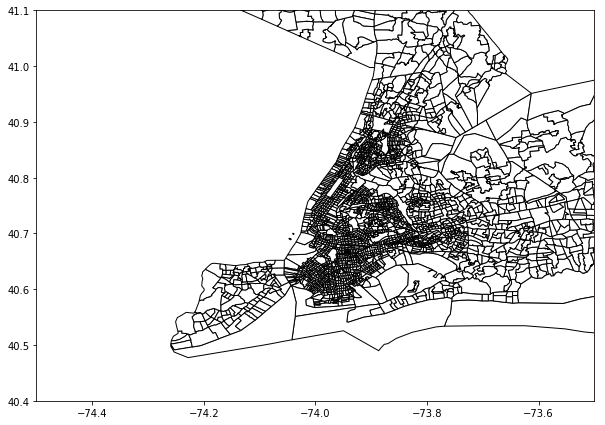

In [106]:
# trying out our new geodataframe for central NYC
df[df["state"]==36].plot(figsize=(10,12),facecolor="white",edgecolor="black")
plt.xlim(-74.5,-73.5)
plt.ylim(40.4,41.1)

# Joining user positions to census tracts

In [107]:
import metro_network as mn

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = 10,7

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns

In [108]:
# loading metro network class, boston data
boston = mn.MetroNetwork("boston")

Creating full nodelist... Done.
Creating full edgelist... Done.
Creating networkx graph representation... Done.
Calculating giant component... Done.
Community detection on gc with louvain... Done.
Community centroid coordinates... Done.


In [109]:
# projecting census tract geometries into the same Cartesian coordinate system as the user coordinates
df.crs = {'init': 'epsg:' + str(boston.init_crs)}
df.to_crs(epsg = boston.project_crs, inplace=True)

In [110]:
# creating a spatial index on the census tract geometries for faster join
si = df.sindex

In [111]:
# storing indices of census tracts where the 1e-5 radius circle around the user home points
# intersect with census tract polygons (it might still be more than 1, but significantly less
# than all of the census tracts!)
# see https://github.com/gboeing/urban-data-science/blob/master/19-Spatial-Analysis-and-Cartography/rtree-spatial-indexing.ipynb
boston.nodelist['possible_home_matches'] = gpd.GeoSeries(
    boston.nodelist['geom_home']
).buffer(1e-5).map(lambda g: list(si.intersection(g.bounds)))

# filtering the previous possible matches list to the actual polygon containing the home geom point
boston.nodelist["home_matches"] = \
    boston.nodelist.apply(
        lambda row: [i for i in row["possible_home_matches"] if df.iloc[i]["geometry"].contains(row["geom_home"])],
        axis=1
    )

In [114]:
# users with geom_home somehow still belonging to more than one census tract 
boston.nodelist[boston.nodelist["home_matches"].map(len)>1]

,user_id,lon_home,lat_home,lon_work,lat_work,geom_home,geom_work,commuting_distance,community,d_community_home,d_community_work,possible_home_matches,home_matches
895,52732073,-71.090371,42.342476,-71.090371,42.342476,POINT (-7913743.916737531 5212419.617895128),POINT (-7913743.916737531 5212419.617895128),0.000000,NaN,NaN,NaN,"[13197, 13198, 13154]","[13197, 13198]"
2150,261040181,-71.083720,42.283354,-71.062988,42.351855,POINT (-7913003.501574529 5203519.39988387),POINT (-7910695.687150662 5213832.179289233),10.567849,16.0,9.780779,3.57244,"[13014, 13063]","[13014, 13063]"


In [115]:
# same for workplaces
boston.nodelist['possible_work_matches'] = gpd.GeoSeries(
    boston.nodelist['geom_work']
).buffer(1e-5).map(lambda g: list(si.intersection(g.bounds)))

boston.nodelist["work_matches"] = \
    boston.nodelist.apply(
        lambda row: [i for i in row["possible_work_matches"] if df.iloc[i]["geometry"].contains(row["geom_work"])],
        axis=1
    )

In [116]:
# users with geom_work somehow still belonging to more than one census tract 
boston.nodelist[boston.nodelist["work_matches"].map(len)>1]

,user_id,lon_home,lat_home,lon_work,lat_work,geom_home,geom_work,commuting_distance,community,d_community_home,d_community_work,possible_home_matches,home_matches,possible_work_matches,work_matches
895,52732073,-71.090371,42.342476,-71.090371,42.342476,POINT (-7913743.916737531 5212419.617895128),POINT (-7913743.916737531 5212419.617895128),0.000000,NaN,NaN,NaN,"[13197, 13198, 13154]","[13197, 13198]","[13197, 13198, 13154]","[13197, 13198]"
3594,497862999,-70.986481,42.373954,-71.035860,42.373391,POINT (-7902178.937134259 5217161.533943543),POINT (-7907675.718818466 5217076.800462232),5.497435,NaN,NaN,NaN,"[13135, 13134, 13126, 13092]",[13126],"[13134, 13031, 13101]","[13031, 13101]"


In [120]:
def get_tract(l):
    if len(l)==1:
        return df.iloc[l[0]]["geoid"]
    else:
        return None

In [121]:
boston.nodelist["tract_home"] = boston.nodelist["home_matches"].map(get_tract)
boston.nodelist["tract_work"] = boston.nodelist["work_matches"].map(get_tract)

In [122]:
boston.nodelist.head()

,user_id,lon_home,lat_home,lon_work,lat_work,geom_home,geom_work,commuting_distance,community,d_community_home,d_community_work,possible_home_matches,home_matches,possible_work_matches,work_matches,tract_home,tract_work
0,10396,-71.191769,42.353000,-71.076132,42.350403,POINT (-7925031.510395316 5214004.710448696),POINT (-7912158.76630233 5213613.524006854),12.878687,NaN,NaN,NaN,"[12522, 12692]",[12522],"[13200, 13074]",[13200],14000US25017373500,14000US25025010702
1,10849,-71.074172,42.345715,-71.055196,42.364927,POINT (-7911940.66876644 5212907.393969067),POINT (-7909828.221452811 5215801.492730942),3.583049,NaN,NaN,NaN,"[13059, 13074, 13032]",[13032],"[13057, 13027]",[13057],14000US25025070300,14000US25025030400
2,23543,-71.156440,42.350100,-71.059770,42.358430,POINT (-7921098.667462124 5213567.853036073),POINT (-7910337.412287137 5214822.656423596),10.834166,0.0,6.214101,3.611380,"[13071, 13069]",[13071],"[13189, 13007]",[13007],14000US25025000202,14000US25025030300
3,78783,-71.138372,42.385084,-71.207524,42.384547,POINT (-7919087.356728987 5218838.788869985),POINT (-7926785.310237302 5218757.926483421),7.698378,NaN,NaN,NaN,"[12502, 12590]",[12590],"[12566, 12773, 12576, 12556]",[12566],14000US25017354400,14000US25017369100
4,623033,-71.098741,42.357838,-71.056443,42.355066,POINT (-7914675.685850378 5214733.435100925),POINT (-7909967.082488043 5214315.925699982),4.727077,1.0,0.199576,4.279256,"[12732, 13136]",[12732],"[13189, 13007]",[13189],14000US25017353102,14000US25025070101


# join the collected census data

In [151]:
import os
path = '../data/'
os.chdir(path)
census_files = glob.glob('censusdata-top50-20*.csv')
census_files.sort()
census_files = census_files[3:]

In [152]:
def create_geoid(row):
    """
    Returns geoid of a census tract from state, county and tract FIPS codes.
    """
    state = str(int(row["state"])).zfill(2)
    county = str(int(row["county"])).zfill(3)
    tract = str(int(row["tract"])).zfill(6)
    return "14000US" + state + county + tract

In [153]:
def rearrange_censusdata(data, columns):
    data['tract_id'] = data.apply(create_geoid, axis=1)
    data = data[data.columns.intersection(columns)]
    return data

In [154]:
census_files

['censusdata-top50-2018.csv',
 'censusdata-top50-2019.csv',
 'censusdata-top50-2020.csv']

In [155]:
census1217 = pd.read_csv("censustract_acs_2012_2017.csv", sep=";")
census1217.shape

(38788, 55)

In [156]:
cols = ['tract_id', 'population', 'income', 'education_bachelor',
       'education_total', 'race_total', 'white', 'black',
       'native', 'asian']

census1217 = pd.merge(
    census1217, rearrange_censusdata(pd.read_csv(census_files[0]), cols),
    on="tract_id", how="left"
)

census1217 = pd.merge(
    census1217, rearrange_censusdata(pd.read_csv(census_files[1]), cols),
    on="tract_id", how="left", suffixes=["2018", "2019"]
)

census1217 = pd.merge(
    census1217, rearrange_censusdata(pd.read_csv(census_files[2]), cols),
    on="tract_id", how="left"
)

census1217 = census1217.rename(columns = {'population' : 'population2020',
                                         'income' : 'income2020',
                                          'education_bachelor' : 'education_bachelor2020',
                                          'education_total' : 'education_total2020',
                                          'race_total' : 'race_total2020',
                                          'white' : 'white2020',
                                          'black' : 'black2020',
                                          'native' : 'native2020',
                                          'asian' : 'asian2020'})

In [157]:
census1217.to_csv("../data/censusdata2012_2020.csv", sep=";", index=0)

In [159]:
test = pd.read_csv("../data/censusdata2012_2020.csv", sep=";")
test.shape

(38788, 82)